In [70]:
# Importing necessary libraries
import os
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [71]:
# Controlling Randomness for Reproducibility
os.environ['PYTHONHASHSEED'] = str(1)
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
C_Random_State = 0
i = 0

In [72]:
# Definitions
C_Royalty = ['Jonkheer', 'Lady', 'Countess', 'Don', 'Dona']
C_Service = ['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Sir']
C_Commons = ['Mr', 'Miss', 'Ms', 'Master', 'Mlle', 'Mme', 'Mrs']
C_Root = '/content/drive/MyDrive/Titanic'

In [73]:
def get_title(x):
  x = re.findall(r'[,\s]{1,}[A-Za-z]{1,}[.]{1,}', x)[0]
  x = re.sub(r'[^A-Za-z]', '', x)
  return x

def preprocess(df):
  df.Age.fillna(value = df.Age.mean(skipna = True), inplace=True)
  df.Fare.fillna(value = 0.00, inplace=True)
  df['Title'] = df['Name'].apply(get_title)
  new_df = pd.DataFrame()
  new_df['PClass_1'] = [1 if df['Pclass'][i] == 1 else 0 for i in range(len(df))]
  new_df['PClass_2'] = [1 if df['Pclass'][i] == 2 else 0 for i in range(len(df))]
  new_df['PClass_3'] = [1 if df['Pclass'][i] == 3 else 0 for i in range(len(df))]
  new_df['Male'] = [1 if df['Sex'][i] == 'male' else 0 for i in range(len(df))]
  new_df['Female'] = [1 if df['Sex'][i] == 'female' else 0 for i in range(len(df))]
  new_df['Sib_0'] = [1 if df['SibSp'][i] == 0 else 0 for i in range(len(df))]
  new_df['Sib_1'] = [1 if df['SibSp'][i] == 1 else 0 for i in range(len(df))]
  new_df['Sib_2plus'] = [1 if df['SibSp'][i] >= 2 else 0 for i in range(len(df))]
  new_df['Parch_0'] = [1 if df['Parch'][i] == 0 else 0 for i in range(len(df))]
  new_df['Parch_1'] = [1 if df['Parch'][i] == 1 else 0 for i in range(len(df))]
  new_df['Parch_2plus'] = [1 if df['Parch'][i] >= 2 else 0 for i in range(len(df))]
  new_df['Emb_S'] = [1 if df['Embarked'][i] == 'S' else 0 for i in range(len(df))]
  new_df['Emb_C'] = [1 if df['Embarked'][i] == 'C' else 0 for i in range(len(df))]
  new_df['Emb_Q'] = [1 if df['Embarked'][i] == 'Q' else 0 for i in range(len(df))]
  new_df['Fare_0to25'] = [1 if 0.0 <= df['Fare'][i] <= 25.0 else 0 for i in range(len(df))]
  new_df['Fare_25to50'] = [1 if 25.1 <= df['Fare'][i] <= 50.0 else 0 for i in range(len(df))]
  new_df['Fare_50plus'] = [1 if 50.1 <= df['Fare'][i] else 0 for i in range(len(df))]
  new_df['Adult'] = [1 if df['Age'][i] >= 18 else 0 for i in range(len(df))]
  new_df['Child'] = [1 if df['Age'][i] < 18 else 0 for i in range(len(df))]
  new_df['Royalty'] = [1 if df['Title'][i] in C_Royalty else 0 for i in range(len(df))]
  new_df['Service'] = [1 if df['Title'][i] in C_Service else 0 for i in range(len(df))]
  new_df['Commons'] = [1 if df['Title'][i] in C_Commons else 0 for i in range(len(df))]
  return new_df

def get_data():
  data_train = pd.read_csv(f'{C_Root}/train.csv')
  data_test = pd.read_csv(f'{C_Root}/test.csv')
  train_labels = data_train['Survived']
  data_train.drop(['Survived'], axis = 1, inplace=True)
  return data_train, data_test, train_labels


In [74]:
X_tr, X_ts, y_train = get_data()
X_train = preprocess(X_tr)
X_test = preprocess(X_ts)
print(f"X_train Shape : {X_train.shape}")
print(f"X_test Shape  : {X_test.shape}")

X_train Shape : (891, 22)
X_test Shape  : (418, 22)


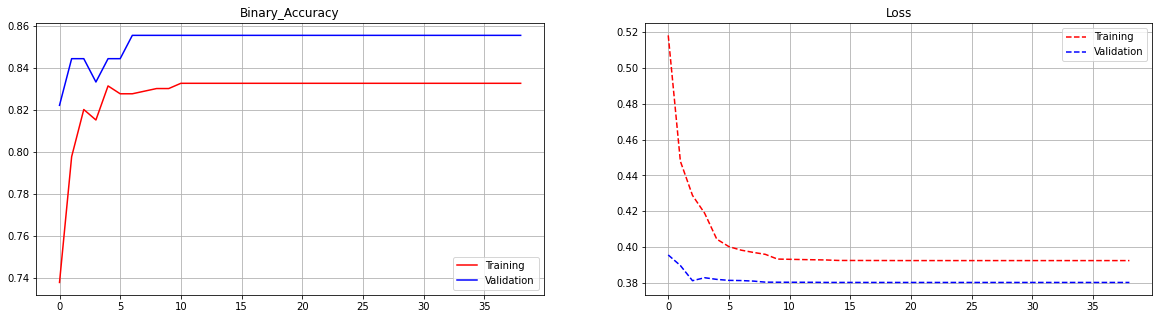

In [83]:
def plot_generator():
    metrics = ['Binary_Accuracy', 'Loss']
    linetype = ['-', '--']
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    epochs = range(len(history.history[metrics[0].lower()]))
    for i in range(len(metrics)):
        axes[i].plot(epochs, history.history[metrics[i].lower()], 'r'+ linetype[i], label = 'Training')
        axes[i].plot(epochs, history.history['val_' + metrics[i].lower()], 'b' + linetype[i] , label = 'Validation')
        axes[i].set_title(metrics[i])
        axes[i].grid(True)
        axes[i].legend()

def lrscheduler(epoch, lr):
  if epoch % 5 == 4:
    return lr * 0.1
  else:
    return lr

def callback_def():
    cb = [
          tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True),
          tf.keras.callbacks.LearningRateScheduler(lrscheduler)
         ]
#    cb = None
    return cb

def build_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(88, activation = 'relu'),
        tf.keras.layers.Dense(2, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), 
                  metrics=tf.keras.metrics.BinaryAccuracy()
                  )
    return model

clf = build_model()
history = clf.fit(X_train, y_train, validation_split = 0.1, epochs = 100, verbose = 0, callbacks = callback_def(), shuffle = False)
plot_generator()
i += 1
clf.save(f"{C_Root}/Titanic{i:03d}.h5", overwrite = True, save_format = 'h5')

In [84]:
C_threshold = 0.5
y_test = [1 if element >= C_threshold else 0 for element in clf.predict(X_test)]
subs = pd.DataFrame({"PassengerId": X_ts['PassengerId'], "Survived": y_test})
subs.to_csv(f"{C_Root}/submission.csv", index = False)